C:\Users\Lenovo\anaconda3\lib\site-packages\numba\core\decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


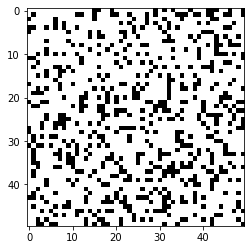

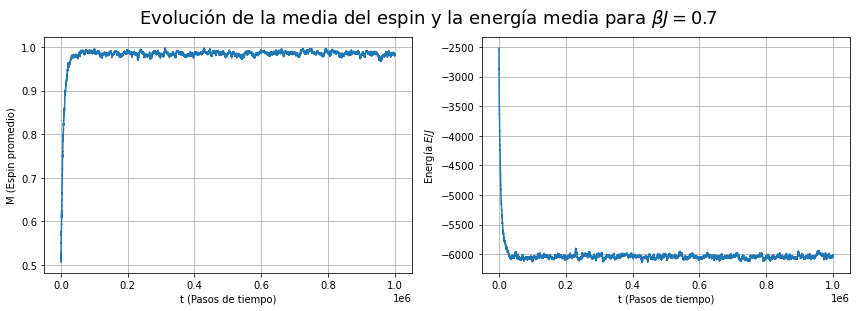

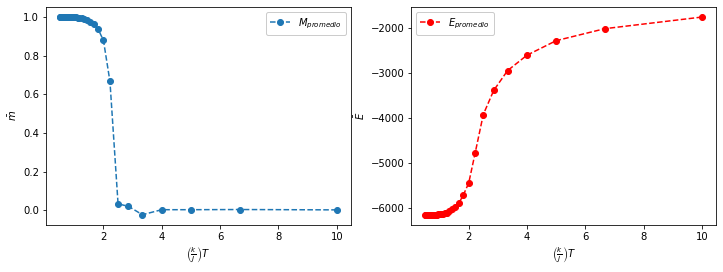

In [5]:
#importamos las librerias necesarias
import numpy as np #Manipulación de matrices
import matplotlib.pyplot as plt #Graficas en 2D
import numba #Libreria de optmización numérica
from numba import njit #Calculo en paralelo
from scipy.ndimage import convolve, generate_binary_structure #Operador de convolucion
%matplotlib inline                                            #y generador de estructura binaria

#Generemos un arreglo bidimiensional de espines
%matplotlib inline
N = 50 #Numero de elementos
matriz_base = np.random.random((N,N)) #Matriz de dimension NxN, los elementos se distribuyen de 
                                       #forma uniforme entre (0,1)
matriz_espin = np.zeros((N,N)) #Matriz de ceros

#Llenamos la matriz de ceros con +1 y -1, aprovechando que las operaciones en python están vectorizadas
matriz_espin[matriz_base>=0.75] = -1 #Si algun elemento de la matriz base es mayor o igual a 50 
                                    #este elemento se llena con +1
matriz_espin[matriz_base<=0.75] = +1
#graficamos el estado inicial con pixeles
plt.imshow(matriz_espin, cmap=plt.cm.gray) #Mapeo, cuadro negro->1, cuadro blanco->-1

#Definimos la función para calcular la energia, aplicando la suma de vecinos mas cercanos
def calcular_energia(matriz):
    nucleo = generate_binary_structure(2,1) #Operador de convolucion
    nucleo[1][1] = False  #Se inicializa en False para obtener la estructura de primeros vecinos
    arreglo = -matriz * convolve(matriz,nucleo,mode='constant',cval=0)
    return arreglo.sum() #Calculamos la suma de los elementos

#Definimos el algoritmo de metropolis
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True) #Optimzacion
def metropolis(spin_arr, times, BJ, energy):  #Funcion que aplica el algoritmo de metropolis
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1) #Matriz donde almacenamos los espines totales
    net_energy = np.zeros(times-1)#Matriz donde almacenamos las energias totales 
    for t in range(0,times-1):
        # Sustituimos la orientacion del espin
        x = np.random.randint(0,N) #Generamos numeros aleatorios enteros entre los valores de 0 a N
        y = np.random.randint(0,N) #Generamos numeros aleatorios enteros entre los valores de 0 a N
        spin_i = spin_arr[x,y] #Espin inicial en la posicion del nodo (x,y)
        spin_f = spin_i*-1 #Valor del espin final 
        
        # Computamos el cambio en la energia 
        E_i = 0 #Inicializmos en cero 
        E_f = 0
        #Condiciones de metropolis
        if x>0: 
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        
        # cambiar de estado con probabilidades designadas
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
            
        net_spins[t] = spin_arr.sum() #La suma total de la matriz de espines
        net_energy[t] = energy #La energia total
   
    return net_spins, net_energy #Nos devuelve el valor de la energia total del sistema y el espin neto

#Hacemos los calculos y dejamos evolucionar al sistema 
espines, energias = metropolis(matriz_espin, 1000000, 0.7, calcular_energia(matriz_espin))

#Graficamos
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(espines/N**2)
ax.set_xlabel('t (Pasos de tiempo)')
ax.set_ylabel(r'M (Espin promedio)')
ax.grid()
ax = axes[1]
ax.plot(energias)
ax.set_xlabel('t (Pasos de tiempo)')
ax.set_ylabel(r'Energía $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolución de la media del espin y la energía media para $\beta J=$0.7', y=1.07, size=18)
plt.show()

#Tomemos diferentes valores para βJ 
def obtener_energia_espin(arreglo, BJs): #BJs son diferentes valores de βJ
    ms = np.zeros(len(BJs))
    E_prom = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(arreglo, 1000000, bj, calcular_energia(matriz_espin))
        ms[i] = spins[-100000:].mean()/N**2
        E_prom[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
    return ms, E_prom, E_stds#Desviacion estandar
    
BJs = np.arange(0.1, 2, 0.05) #
ms_n, E_prom_n, E_stds_1 = obtener_energia_espin(matriz_espin, BJs)
#ms_p, E_prom_p, E_stds_2 = obtener_energia_espin(matriz_espin_2, BJs)
fig,axes=plt.subplots(1,2,figsize=(12,4))
ax1=axes[0]
ax1.plot(1/BJs, ms_n, 'o--', label='$M_{promedio}$')
ax1.set_xlabel(r'$\left(\frac{k}{J}\right)T$')
ax1.set_ylabel(r'$\bar{m}$')
ax1.grid
ax1.legend(facecolor='white', framealpha=1)
ax1=axes[1]
ax1.plot(1/BJs, E_prom_n , 'ro--', label='$E_{promedio}$')
ax1.set_xlabel(r'$\left(\frac{k}{J}\right)T$')
ax1.set_ylabel(r'$\bar{E}$')
ax1.grid
ax1.legend(facecolor='white', framealpha=1)
plt.show()
